In [43]:
from IPython import display

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf

#import mbrl.env.pets_reacher as Reacher3DEnv
import mbrl.env.pets_halfcheetah as halfcheetah_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns

# all the mbrl.models sub-class the
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

from REAI.physics_models import SINDyModel, CartpoleModel
from REAI.physics_models import trajectories_from_replay_buffer
#from utils import check_physics_model


device = "cuda:0" if torch.cuda.is_available() else "cpu"

trial_length = 1000
num_trials = 10
ensemble_size = 1
rendering = True
seed = 0


physics_config = {
    'phys_nn_config' : 2,                   
    # options:  
    # 0: no physics model, only pets
    # 1: additive composition: 
    #    mean = physics_model(x) + Pets(x), logvar = Pets(x) 
    # 2: physics model prediction pass through pets
    #   mean, logvar = NN(concat(physics_model.predict(state, action), state, action)
    #3: only physics model, no NN
    'physics_model' : 'sindy',               
    # options: sindy/cartpole
    'model_kwargs' : { 'backend' : 'sindy',
                       'noise_level' : 0.0 , 
                       'predict_delta' : True} , 
    # options for sindy: 'backend' : 'torch', 'sindy', 'dask'

    }


# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",  # NOTE: important we are using a GAUSSIANMLP Here --
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "in_features": "???",
        "out_size": "???",
        "deterministic": False,  # probabilistic model
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {"_target_": "torch.nn.LeakyReLU", "negative_slope": 0.01},
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05,
    },
}

agent_cfg = omegaconf.OmegaConf.create(
    {
        # this class evaluates many trajectories and picks the best one
        "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
        "planning_horizon": 15,
        "replan_freq": 1,
        "verbose": False,
        "action_lb": "???",
        "action_ub": "???",
        # this is the optimizer to generate and choose a trajectory
        "optimizer_cfg": {
            "_target_": "mbrl.planning.CEMOptimizer",
            "num_iterations": 5,
            "elite_ratio": 0.1,
            "population_size": 500,
            "alpha": 0.1,
            "device": device,
            "lower_bound": "???",
            "upper_bound": "???",
            "return_mean_elites": True,
            "clipped_normal": False,
            #for iCEM
            #"keep_elite_frac" : 0.1,
            #"population_decay_factor":  0.9, 
            #"colored_noise_exponent": 0.5,
        },
    }
)


#def run():
env = halfcheetah_env.HalfCheetahEnv()
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole


phys_nn_config = physics_config['phys_nn_config']
physics_model = physics_config['physics_model']

if phys_nn_config == 2:
    cfg_dict["dynamics_model"]["in_features"] = 2 * obs_shape[0] + (act_shape[0] if act_shape else 1)
    print('overriding in_features to ', cfg_dict["dynamics_model"]["in_features"])

if phys_nn_config == 3:
    cfg_dict["dynamics_model"]["deterministic"] = True
    print('overriding deterministic to True')

cfg = omegaconf.OmegaConf.create(cfg_dict)

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)
dynamics_model.model.phys_nn_config = phys_nn_config

if physics_model == 'sindy':
    dynamics_model.model.physics_model = SINDyModel(**physics_config['model_kwargs']) # change backend to 'torch' to run on GPU

elif physics_model == 'cartpole':
    dynamics_model.model.physics_model = CartpoleModel(**physics_config['model_kwargs'])


# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnv(
    env, dynamics_model, term_fn, reward_fn, generator=generator
)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

common_util.rollout_agent_trajectories(
    env,
    trial_length,  # initial exploration steps
    planning.RandomAgent(env),
    {},  # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length,
)


# pretrain Sindy model on random trajectories
if isinstance(dynamics_model.model.physics_model, SINDyModel):
    dynamics_model.model.physics_model.train(replay_buffer)

overriding in_features to  42


In [44]:
replay_buffer.obs.shape

(10000, 18)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from copy import deepcopy


#check physics model
def check_physics_model(replay_buffer, physics_model):
    '''
    physics_model = dynamics_model.model.physics_model
    '''

    trajectories_list, action_list  = trajectories_from_replay_buffer(replay_buffer)
    test_trajectory = trajectories_list[0]
    test_actions = action_list[0]

    predicted_states = []
    predict_recursively = []
    init_state = deepcopy(test_trajectory[0])

    cur_state = init_state
    #for i in range(len(test_trajectory)):
    for i in range(50):
        state = torch.tensor(test_trajectory[i])
        action = torch.tensor(test_actions[i])
        
        #predicting recursively (from its own prediction)
        if physics_model.predict_delta:
            next_state = np.array(physics_model.predict(torch.tensor(cur_state), action) + cur_state)
        else:
            next_state = np.array(physics_model.predict(torch.tensor(cur_state), action))
        predict_recursively.append(next_state)
        cur_state = next_state
        
        #predicting from actual state
        if physics_model.predict_delta:
            pred_state = np.array(physics_model.predict(state, action) + state)
        else:
            pred_state = np.array(physics_model.predict(state, action))
        predicted_states.append(pred_state)

    predicted_states = np.array(predicted_states)
    predict_recursively = np.array(predict_recursively)

    plt.figure(figsize=(10,15))
    state_dims = state.shape[0]
    for j in range(state_dims):
        plt.subplot(state_dims, 2, 2*j + 1)
        plt.plot( predicted_states[:-1, j] ,  label='model prediction from state')
        plt.plot( predict_recursively[:-1, j] ,  label='model prediction recursive')        
        plt.plot( test_trajectory[1:50, j],  label='true trajectory')
        if j== state_dims - 1:
            plt.legend()


        plt.subplot(state_dims, 2, 2 *j + 2)
        plt.plot( np.abs(predicted_states[:-1, j] - test_trajectory[1:50, j])  ,  label='model prediction from state')
        #plt.plot( np.abs(predicted_states_own[:-1, j]- test_trajectory[1:, j]) ,  label='model prediction recursive')        
        plt.title('Errors')
    plt.show()



# samples stored 1000
total steps:  1000


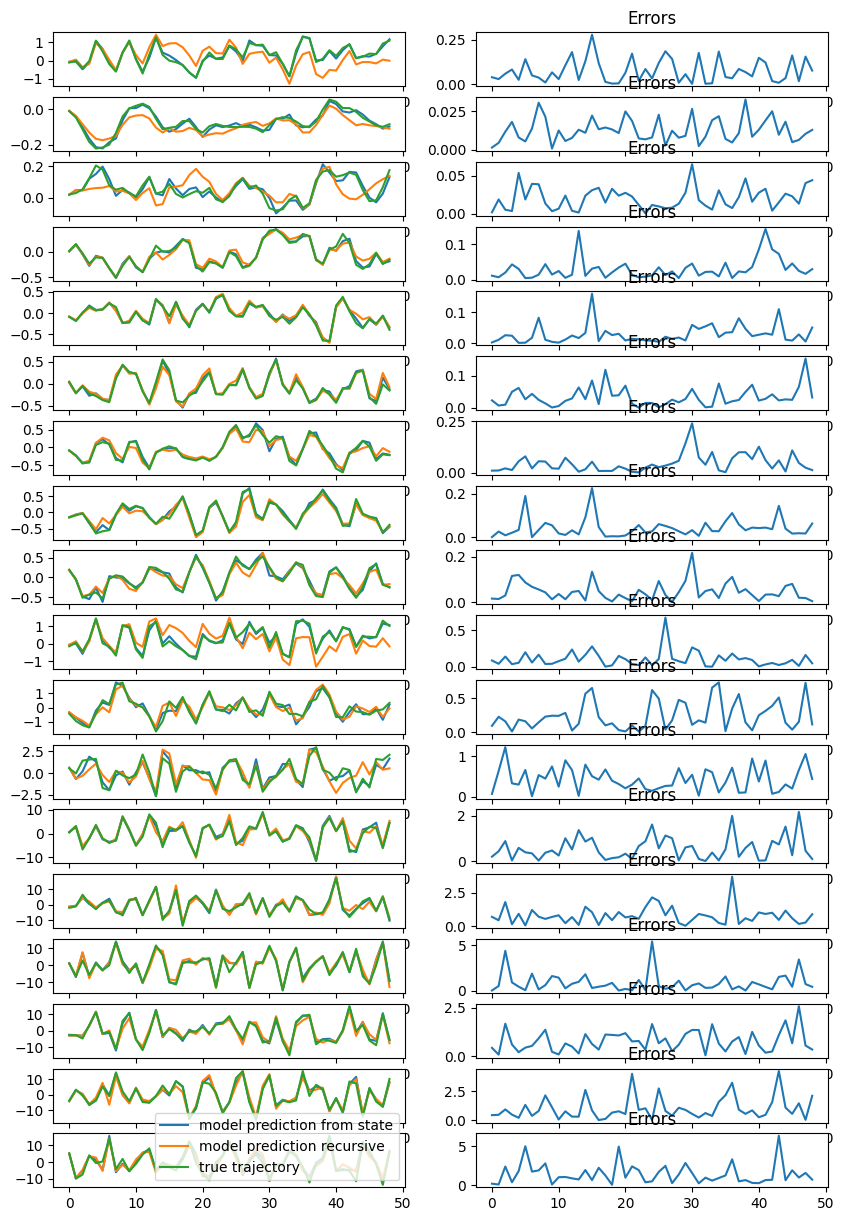

TypeError: cannot unpack non-iterable NoneType object

In [54]:
predicted_states, predicted_states_own = check_physics_model(replay_buffer, dynamics_model.model.physics_model)
print("num stored", replay_buffer.num_stored)
print("# samples stored", replay_buffer.num_stored)

print(predicted_states)  
print(predicted_states_own)

In [36]:
trajectories_from_replay_buffer(replay_buffer)[0][1].shape

# samples stored 1000
total steps:  1000


IndexError: list index out of range